In [1]:
import pyro
import pyro.distributions as dist
import torch
from pyro.infer.autoguide import AutoGuideList, AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Simple Bayesian experimment to model wait times with a Gamma prior and Exponential likelihood

def model_wait_times(t):
    # t is a 1D tensor of observed wait times
    alpha0 = torch.tensor(1.0)   # shape
    beta0  = torch.tensor(1.0)   # rate

    # Conjugate Prior is a Gamma distribution
    lam = pyro.sample("lambda", dist.Gamma(alpha0, beta0))

    # Likelihood is an Exponential distribution, whose 'lambda' parameter is defined by the conjugate prior
    # The likelihood in a Bayesian experiment models your 'process' that generates the data. The conjugate prior is a guess at that process's parameter(s).
    # So we essentially have two guesses: one for the process, and one for the process's parameters. This 'double-layered guess' is common to all Bayesian experiments.
    with pyro.plate("data", len(t)):
        pyro.sample("t_obs", dist.Exponential(lam), obs=t)



def fit_svi(t, steps=2000, lr=0.02):
    guide = AutoGuideList(model_wait_times)
    # Conjugate here is analytic, but we can still use a simple guide:
    guide.append(AutoDelta(model_wait_times))  # point-estimate (MAP); swap for AutoNormal for full approx

    svi = SVI(model_wait_times, guide, Adam({"lr": lr}), loss=Trace_ELBO())
    t_tensor = torch.as_tensor(t, dtype=torch.float32)

    for _ in range(steps):
        svi.step(t_tensor)

    post = guide.median({"t": t_tensor})  # contains "lambda"
    return float(post["lambda"])

# Posterior predictive sampling for next wait time
def sample_posterior_predictive(t, num_samples=1000):
    # Conjugate posterior parameters
    t = torch.as_tensor(t, dtype=torch.float32)
    alpha_post = 1.0 + t.numel()
    beta_post  = 1.0 + t.sum()
    lam_samps = dist.Gamma(alpha_post, beta_post).sample((num_samples,))
    # Predictive for next waiting time by mixing Exponential over posterior λ
    t_new = dist.Exponential(lam_samps).sample()
    return t_new

/Users/andrew.lehe/Documents/probabilistic_sandbox/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def visualize_bayesian_elements(t, num_samples=5000):
    """
    Visualize prior vs posterior over lambda and posterior predictive distribution.
    This does not modify any of the original model or inference code.
    """
    t = torch.as_tensor(t, dtype=torch.float32)

    # Prior parameters (from your model)
    alpha0 = 1.0
    beta0 = 1.0

    # Posterior parameters (conjugate)
    alpha_post = alpha0 + t.numel()
    beta_post = beta0 + t.sum()

    # Draw samples from prior and posterior over λ
    lam_prior = dist.Gamma(alpha0, beta0).sample((num_samples,))
    lam_post = dist.Gamma(alpha_post, beta_post).sample((num_samples,))

    # Posterior predictive samples
    t_new = dist.Exponential(lam_post).sample()

    # Plotting
    plt.figure(figsize=(14, 4))

    # Plot prior vs posterior over lambda
    plt.subplot(1, 2, 1)
    sns.kdeplot(lam_prior.numpy(), label='Prior λ', fill=True)
    sns.kdeplot(lam_post.numpy(), label='Posterior λ', fill=True)
    plt.xlabel('λ')
    plt.ylabel('Density')
    plt.title('Prior vs Posterior over λ')
    plt.legend()

    # Plot posterior predictive for next wait time
    plt.subplot(1, 2, 2)
    sns.kdeplot(t_new.numpy(), fill=True)
    plt.xlabel('Predicted wait time')
    plt.ylabel('Density')
    plt.title('Posterior Predictive Distribution')

    plt.tight_layout()
    plt.show()


Posterior MAP λ ≈ 0.732


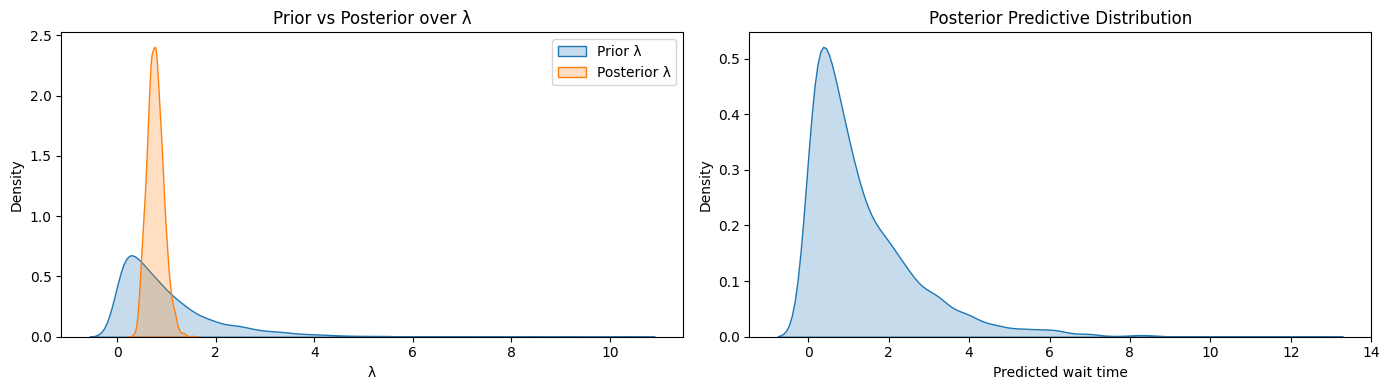

In [3]:
observed_waits = torch.distributions.Exponential(0.5).sample((20,)).numpy()

# Fit model
lam_map = fit_svi(observed_waits)
print(f"Posterior MAP λ ≈ {lam_map:.3f}")

# Visualize prior/posterior/predictive
visualize_bayesian_elements(observed_waits)